In [11]:
pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=f3542499d23666da557a32e3f57962ffc79d9f13cb2298edb504f232c7325591
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [12]:
import pandas as pd
import pyspark.sql 


In [ ]:
#@title Default title text
## Download Input dataset for analytics
# https://propensity-labs-screening.s3.amazonaws.com/analytics/analytics_input.csv

In [13]:
#Create Spark Session
from pyspark.sql import SparkSession

spark =SparkSession.builder.getOrCreate ()

In [ ]:
#Read CSV to Dataframe
filepath = '/content/sample_data/analytics_input.csv'

DF = spark.read.format('csv') \
.option('inferSchema','true') \
.option('header','true')\
.load(filepath)

In [ ]:
#Display Scheme
DF.printSchema()

root
 |-- DRG Definition: string (nullable = true)
 |-- Provider Id: string (nullable = true)
 |-- Provider Name: string (nullable = true)
 |-- Provider Street Address: string (nullable = true)
 |-- Provider City: string (nullable = true)
 |-- Provider State: string (nullable = true)
 |-- Provider Zip Code: integer (nullable = true)
 |-- Hospital Referral Region Description: string (nullable = true)
 |--  Total Discharges : integer (nullable = true)
 |--  Average Covered Charges : string (nullable = true)
 |--  Average Total Payments : string (nullable = true)
 |-- Average Medicare Payments: string (nullable = true)



In [ ]:
from pyspark.sql.functions import upper



#Change Column names to remove spaces, lower case and replace spaces in column names with "_" (underscore)

rDF = [i.replace(" ","_") for i in DF.columns]

df2= DF.toDF(*rDF)

df3 = df2.toDF(*[c.upper() for c in df2.columns])

df3.show(10)


+--------------------+-----------+--------------------+-----------------------+-------------+--------------+-----------------+------------------------------------+------------------+-------------------------+------------------------+-------------------------+
|      DRG_DEFINITION|PROVIDER_ID|       PROVIDER_NAME|PROVIDER_STREET_ADDRESS|PROVIDER_CITY|PROVIDER_STATE|PROVIDER_ZIP_CODE|HOSPITAL_REFERRAL_REGION_DESCRIPTION|_TOTAL_DISCHARGES_|_AVERAGE_COVERED_CHARGES_|_AVERAGE_TOTAL_PAYMENTS_|AVERAGE_MEDICARE_PAYMENTS|
+--------------------+-----------+--------------------+-----------------------+-------------+--------------+-----------------+------------------------------------+------------------+-------------------------+------------------------+-------------------------+
|039 - EXTRACRANIA...|      10001|SOUTHEAST ALABAMA...|   1108 ROSS CLARK C...|       DOTHAN|            AL|            36301|                         AL - Dothan|                91|                $32963.07|            

In [ ]:
from pyspark.sql.functions import column,when,count
import numpy as np
#Identify all rows with Null values for provider id
import pandas as pd


df4= df3.select([count(when (column('PROVIDER_ID').isNull(), True))])

df4.toPandas()

,count(CASE WHEN (PROVIDER_ID IS NULL) THEN true END)
0,0


In [180]:
from pickle import TRUE
#Change fields with Payment information into numbers by using Lambda functions in python
from pyspark.sql.functions import col, udf 
from pyspark.sql.types import DoubleType
import numpy as np
import pandas as pd


covert= udf(lambda x: float(x.replace('$','')), DoubleType())
df5 =df3.withColumn("AVERAGE_COVERED_CHARGES_Con", covert(col("_AVERAGE_COVERED_CHARGES_"))).withColumn("AVERAGE_TOTAL_PAYMENTS_Con", covert(col("_AVERAGE_TOTAL_PAYMENTS_"))).withColumn("AVERAGE_MEDICARE_PAYMENTS_Con", covert(col("AVERAGE_MEDICARE_PAYMENTS")))


df5.show()

+--------------------+-----------+--------------------+-----------------------+-------------+--------------+-----------------+------------------------------------+------------------+-------------------------+------------------------+-------------------------+---------------------------+--------------------------+-----------------------------+
|      DRG_DEFINITION|PROVIDER_ID|       PROVIDER_NAME|PROVIDER_STREET_ADDRESS|PROVIDER_CITY|PROVIDER_STATE|PROVIDER_ZIP_CODE|HOSPITAL_REFERRAL_REGION_DESCRIPTION|_TOTAL_DISCHARGES_|_AVERAGE_COVERED_CHARGES_|_AVERAGE_TOTAL_PAYMENTS_|AVERAGE_MEDICARE_PAYMENTS|AVERAGE_COVERED_CHARGES_Con|AVERAGE_TOTAL_PAYMENTS_Con|AVERAGE_MEDICARE_PAYMENTS_Con|
+--------------------+-----------+--------------------+-----------------------+-------------+--------------+-----------------+------------------------------------+------------------+-------------------------+------------------------+-------------------------+---------------------------+-----------------------

In [215]:
df6.show(10)

+--------------------+-----------+--------------------+-----------------------+-------------+--------------+-----------------+------------------------------------+------------------+-------------------------+------------------------+-------------------------+---------------------------+--------------------------+-----------------------------+
|      DRG_DEFINITION|PROVIDER_ID|       PROVIDER_NAME|PROVIDER_STREET_ADDRESS|PROVIDER_CITY|PROVIDER_STATE|PROVIDER_ZIP_CODE|HOSPITAL_REFERRAL_REGION_DESCRIPTION|_TOTAL_DISCHARGES_|_AVERAGE_COVERED_CHARGES_|_AVERAGE_TOTAL_PAYMENTS_|AVERAGE_MEDICARE_PAYMENTS|AVERAGE_COVERED_CHARGES_Con|AVERAGE_TOTAL_PAYMENTS_Con|AVERAGE_MEDICARE_PAYMENTS_Con|
+--------------------+-----------+--------------------+-----------------------+-------------+--------------+-----------------+------------------------------------+------------------+-------------------------+------------------------+-------------------------+---------------------------+-----------------------

In [ ]:
from sqlalchemy.sql.expression import select
#Plot a Bar chart by state and "Average Total Payments" and zip code vs "total_charges"
import pandas as pd
import matplotlib.pyplot as plot
from pyspark.sql.functions import col


colum1 = df6.select(column("PROVIDER_STATE"))
colum2 = df6.select(column("AVERAGE_TOTAL_PAYMENTS_Con"))

agg= df6.groupBy(colum1).agg({colum2: "sum"})

agg2= agg_df.toPandas()

x=agg2[colum1]
y=agg2[colum2]

plt.bar(x,y)
plot.ylabel("PROVIDER_STATE")
plot.xlabel("Death AVERAGE_TOTAL_PAYMENTS_Con")

Text(0.5, 0, 'Death AVERAGE_TOTAL_PAYMENTS_Con')

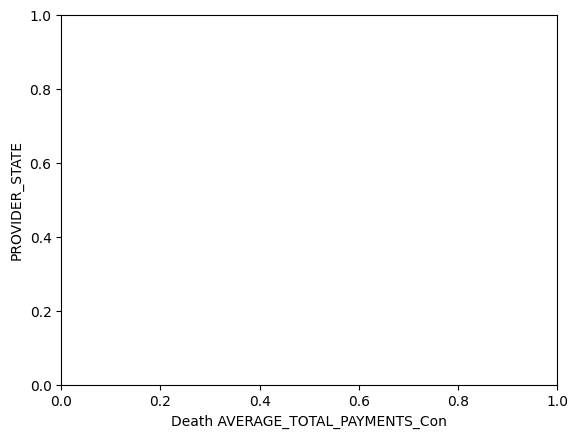

In [ ]:
#BONUS - Plot intersting statistics from the dataset


In [ ]:
df = df5.withColumn("state", df["state_column"])

# Write the DataFrame to a Parquet format partitioned by the "state" column
df5.write.partitionBy("state").parquet("output_directory.parquet")